# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [47]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def get_dprinter(debug=True):
    def dprint(*args, **kwargs):
        if debug:
            print(*args, **kwargs)     
    return dprint

    
def build_hamiltonian(mol):
    E_nuc = mol.energy_nuc()
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    H_mat = H_mat + E_nuc * np.eye(H_mat.shape[0])
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    E_HF = myhf.e_tot

    return H_mat, E_fci, E_HF


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=5000, step_starting_shift_upd=500, n_prod=2500,
           shift_upd_interval=10, dt=0.001, damping=0.05, debug=True):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて基底状態エネルギーを推定する。

    Args:
        mol: PySCFのMoleculeオブジェクト
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        n_prod: E_projの平均を計算するステップ数（処理完了時からこのステップ数遡って平均を取る）
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ
        debug: デバッグモード
        

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """
    dprint = get_dprinter(debug)
    
    H_mat, E_fci, E_HF = build_hamiltonian(mol)
    H_mat = H_mat - np.eye(H_mat.shape[0]) * E_HF
    dprint(f"--- K Matrix shape:{H_mat.shape} ---")
    dprint(H_mat)
    
    E_est = 0
    hist_population = np.zeros(n_steps)
    hist_shift = np.zeros(n_steps)
    hist_energy = np.zeros(n_steps)
    
    diag_H = np.diag(H_mat)    
    n_det = H_mat.shape[0]
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    # walkers = {ref_det_idx: init_n_walker}
    walkers = np.zeros(n_det, dtype=np.int32)
    walkers[ref_det_idx] = init_n_walker

    tqdm_pbar = tqdm(range(n_steps))
    for step in tqdm_pbar:
        target_det_idx = np.flatnonzero(walkers)
        target_walkers = walkers[target_det_idx]
        n_target_det = target_det_idx.shape[0]
        
        # ----- Spawning Step -----
        # walkerのspawn先determinantをランダムに決める
        # spawn元インデックスを避けてspawn先インデックスを生成
        # det_idx = np.arange(n_target_det)
        t_idx = np.random.randint(0, n_det-1, size=n_target_det)
        t_idx += (t_idx >= target_det_idx)

        # spawn確率を計算
        h_ij = H_mat[target_det_idx, t_idx]
        p_gen = 1/(n_det-1)
        prob_spawn = dt * abs(h_ij) / p_gen
        frac_prob_spawn, int_prob_spawn = np.modf(prob_spawn)

        # spawn確率の整数部分は確定spawn
        n_spawn = int_prob_spawn.astype(np.int32)
        # 小数部分は確率的にspawn
        n_spawn += np.random.binomial(abs(target_walkers), frac_prob_spawn)

        # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerをspawn
        signs = np.sign(target_walkers)
        signs[h_ij > 0] *= -1
        n_spawn *= signs
        # new_walkers = np.zeros(n_target_det, dtype=np.int32)
        # print('new_walkers:', new_walkers)
        # print('t_idx:', t_idx)
        # print('n_spawn:', n_spawn)
        # np.add.at(new_walkers, t_idx, n_spawn)

        # ----- Diagonal Step (Death/Cloning) -----
        prob_death = dt * (diag_H[target_det_idx] - shift)
        signs = np.sign(target_walkers)

        # prob_deathの確率でdeath/cloneする（対象となるwalkerの数をカウントする）
        n_dc = np.random.binomial(abs(target_walkers), abs(prob_death))
        # prob_death>0ならwalkerを削除し、<0ならwalkerを複製
        n_dc[prob_death > 0] *= -1
        target_walkers = signs * (abs(target_walkers) + n_dc)
        walkers[target_det_idx] = target_walkers

        # ----- Annihilation Step -----
        # walkers += new_walkers
        np.add.at(walkers, t_idx, n_spawn)

        # # ---- Shift Update -----
        current_pop = np.sum(abs(walkers))
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift

        pre_pop = current_pop
        hist_shift[step] = shift
        hist_population[step] = current_pop

        # ----- Energy Estimation (Projected Energy) -----
        # E_HF2 = diag_H[ref_det_idx]  # これはE_HFではない
        row0 = H_mat[ref_det_idx]
        num_ref = walkers[ref_det_idx]

        # 論文では、singles/doublesに限定して合計している
        # この実装だとそもそもFCI行列の成分がsingles/doubles以外が0になっているので、
        # 全部を合計していて、結局singles/doublesだけが合計されることになっている
        s = row0 * walkers / num_ref
        E_proj = E_HF + np.sum(s[1:])

        # # E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        
        # # 生成したコードでは論文にはない項を足していた
        # # これはハミルトニアンに各反発エネルギーが含まれているかいないかの解釈が論文と異なっているため？
        # # これを含めなければ近い値に収束するので、コメントアウトしておく
        # # E_proj += mol.energy_nuc()
        hist_energy[step] = E_proj

        if step % 1000 == 0:
            tqdm_pbar.set_postfix(n_walkwers=current_pop, shift=f"{shift:.5f}", E_proj=f"{E_proj:.6f}")
            dprint(f'{step} step')
            log_n_walkers(walkers, debug=debug)

    # n_prod件のhist_energyデータを10分割して平均を取り、標準偏差を求める
    n_block = 10
    hist_energy_prod = np.array(hist_energy[-n_prod:])
    block_size = len(hist_energy_prod) // n_block
    hist_energy_prod = hist_energy_prod[:n_block * block_size]  # 小数分を切り捨てる
    blocks = hist_energy_prod.reshape(n_block, block_size)
    block_means = blocks.mean(axis=1)
    E_sd = np.std(block_means, ddof=1)
    E_est = np.mean(block_means)
    
    # E_est = np.mean(hist_energy_prod) # 最後のn_prodステップの平均
    avg_shift = np.mean(hist_shift[-n_prod:]) # 最後のn_prodステップの平均
    
    dprint('\n---- Walkers (result) ----')
    log_n_walkers(walkers, debug=debug)

    return E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy


def log_n_walkers(walkers, debug=True, limit=10):
    dprint = get_dprinter(debug)
    idx = np.argsort(abs(walkers))[::-1]
    sorted_arr = walkers[idx]
    mask = sorted_arr != 0

    idx = idx[mask]
    sorted_arr = sorted_arr[mask]

    for i, v in zip(idx[:limit], sorted_arr[:limit]):
      dprint(f"  {v} walkers on {i}th determinant")

    if sorted_arr.shape[0] > limit:
        dprint("  ... more")
    

def plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')
    plt.grid(True)  

    E_corr = np.full_like(hist_shift, E_fci - E_HF)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift, label="Shift")
    plt.plot(E_corr, linestyle="--", label=r"${E_{corr}}$")
    plt.xlabel('Step')
    plt.ylabel('Shift')
    plt.legend()
    plt.grid(True)  

    E_fci_arr = np.full_like(hist_energy, E_fci)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy, label=r"${E_{proj}}$")
    plt.plot(E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    plt.legend()
    plt.grid(True)  
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出る

--- K Matrix shape:(4, 4) ---
[[ 0.00000000e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16  7.67196412e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01  7.67196412e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  1.57937745e+00]]


 10%|████▎                                     | 2028/20000 [00:00<00:00, 20275.96it/s, E_proj=-1.133233, n_walkwers=48, shift=0.70000]

0 step
  3 walkers on 0th determinant
1000 step
  7 walkers on 0th determinant
  -1 walkers on 3th determinant
2000 step
  13 walkers on 0th determinant
  -1 walkers on 3th determinant
3000 step
  20 walkers on 0th determinant
  -2 walkers on 3th determinant
4000 step
  44 walkers on 0th determinant
  -4 walkers on 3th determinant


 22%|█████████▏                                | 4403/20000 [00:00<00:00, 22308.31it/s, E_proj=-1.133616, n_walkwers=94, shift=0.70000]

5000 step
  86 walkers on 0th determinant
  -8 walkers on 3th determinant


 45%|██████████████████                      | 9059/20000 [00:00<00:00, 22994.60it/s, E_proj=-1.137270, n_walkwers=2026, shift=0.70000]

6000 step
  191 walkers on 0th determinant
  -15 walkers on 3th determinant
7000 step
  408 walkers on 0th determinant
  -39 walkers on 3th determinant
8000 step
  891 walkers on 0th determinant
  -99 walkers on 3th determinant
9000 step
  1820 walkers on 0th determinant
  -206 walkers on 3th determinant


 45%|██████████████████                      | 9059/20000 [00:00<00:00, 22994.60it/s, E_proj=-1.137578, n_walkwers=7443, shift=0.41236]

10000 step
  3855 walkers on 0th determinant
  -384 walkers on 3th determinant
11000 step
  6676 walkers on 0th determinant
  -767 walkers on 3th determinant


 69%|██████████████████████████▏           | 13759/20000 [00:00<00:00, 23126.44it/s, E_proj=-1.137039, n_walkwers=16662, shift=0.05556]

12000 step
  9544 walkers on 0th determinant
  -1156 walkers on 3th determinant
13000 step
  12103 walkers on 0th determinant
  -1386 walkers on 3th determinant
14000 step
  13744 walkers on 0th determinant
  -1523 walkers on 3th determinant
15000 step
  14985 walkers on 0th determinant
  -1677 walkers on 3th determinant


 81%|██████████████████████████████▋       | 16177/20000 [00:00<00:00, 23466.28it/s, E_proj=-1.137053, n_walkwers=17635, shift=0.03343]

16000 step
  15859 walkers on 0th determinant
  -1776 walkers on 3th determinant


100%|█████████████████████████████████████| 20000/20000 [00:00<00:00, 23199.66it/s, E_proj=-1.137070, n_walkwers=19169, shift=-0.01427]


17000 step
  16601 walkers on 0th determinant
  -1904 walkers on 3th determinant
18000 step
  16981 walkers on 0th determinant
  -1968 walkers on 3th determinant
19000 step
  17237 walkers on 0th determinant
  -1932 walkers on 3th determinant

---- Walkers (result) ----
  17452 walkers on 0th determinant
  -1981 walkers on 3th determinant
E_fci=-1.137283834488502, E_HF=-1.1167593073964248
------------------------------
FCI Energy: -1.137284 Ha
FCIQMC Energy: -1.137007 ±  0.000812 Ha


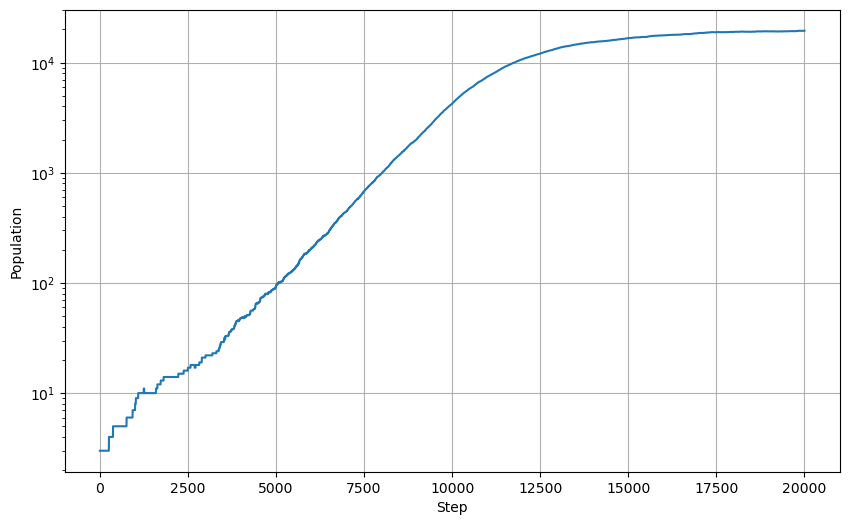

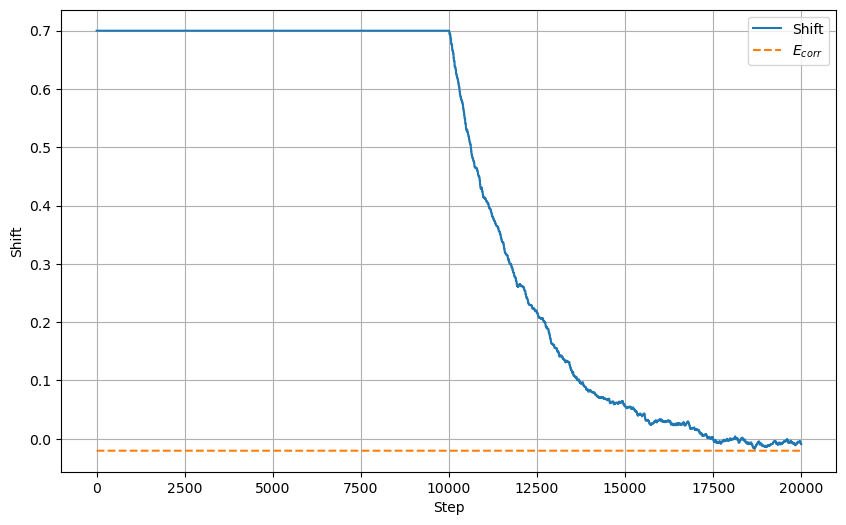

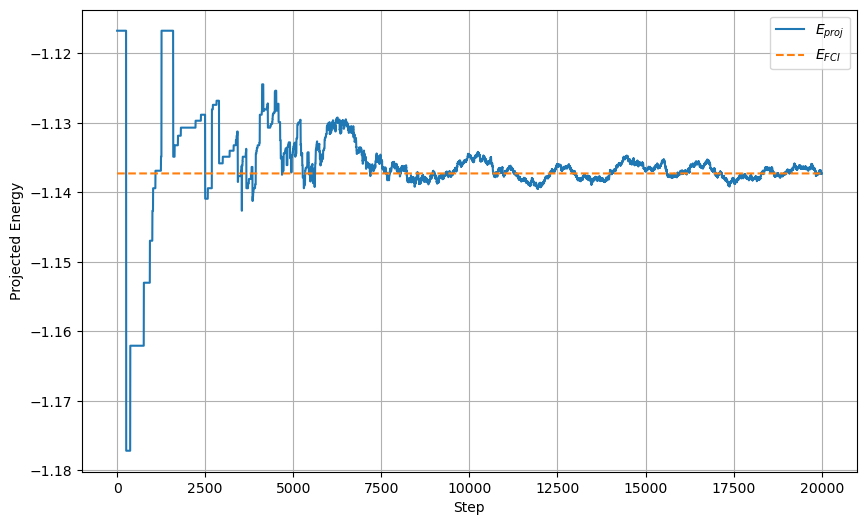

In [49]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)

E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=20000, n_prod=10000, step_starting_shift_upd=10000)

print(f"E_fci={E_fci}, E_HF={E_HF}")

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
# print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- K Matrix shape:(9, 9) ---
[[-4.44089210e-16  2.78282448e-17 -9.82897130e-09  2.78282448e-17
   1.44076448e-01 -4.65022949e-17 -9.82897130e-09 -4.65022949e-17
   1.44076569e-01]
 [ 2.78282448e-17  6.29766527e-01 -4.94150488e-17  1.44076448e-01
   2.23904423e-12 -9.56437226e-02 -4.65022949e-17 -9.56440818e-02
  -2.23896578e-12]
 [-9.82897130e-09 -4.94150488e-17  6.29784244e-01 -4.65022949e-17
  -9.56437226e-02 -2.23892764e-12  1.44076569e-01 -2.23896578e-12
   9.56396165e-02]
 [ 2.78282448e-17  1.44076448e-01 -4.65022949e-17  6.29766527e-01
   2.23904423e-12 -9.56440818e-02 -4.94150488e-17 -9.56437226e-02
  -2.23896578e-12]
 [ 1.44076448e-01  2.23904423e-12 -9.56437226e-02  2.23904423e-12
   1.35961761e+00 -3.38168990e-16 -9.56437226e-02 -3.38168990e-16
   7.58871399e-02]
 [-4.65022949e-17 -9.56437226e-02 -2.23892764e-12 -9.5

 10%|████▏                                     | 2001/20000 [00:00<00:00, 19938.67it/s, E_proj=-1.281934, n_walkwers=53, shift=0.80000]

0 step
  1 walkers on 0th determinant
1000 step
  1 walkers on 0th determinant
2000 step
  2 walkers on 0th determinant
3000 step
  14 walkers on 0th determinant
  -4 walkers on 4th determinant
4000 step
  40 walkers on 0th determinant
  -8 walkers on 4th determinant
  -2 walkers on 8th determinant
  -2 walkers on 6th determinant
  -1 walkers on 2th determinant


 22%|█████████                                 | 4331/20000 [00:00<00:00, 21912.23it/s, E_proj=-1.291940, n_walkwers=98, shift=0.80000]

5000 step
  72 walkers on 0th determinant
  -12 walkers on 8th determinant
  -11 walkers on 4th determinant
  -2 walkers on 6th determinant
  -1 walkers on 2th determinant


 46%|██████████████████▍                     | 9203/20000 [00:00<00:00, 23654.28it/s, E_proj=-1.275423, n_walkwers=4881, shift=0.80000]

6000 step
  157 walkers on 0th determinant
  -22 walkers on 8th determinant
  -22 walkers on 4th determinant
  -3 walkers on 6th determinant
  -1 walkers on 2th determinant
7000 step
  358 walkers on 0th determinant
  -43 walkers on 8th determinant
  -39 walkers on 4th determinant
  -5 walkers on 2th determinant
  -1 walkers on 6th determinant
8000 step
  794 walkers on 0th determinant
  -94 walkers on 4th determinant
  -79 walkers on 8th determinant
  -9 walkers on 2th determinant
  4 walkers on 6th determinant
9000 step
  1773 walkers on 0th determinant
  -189 walkers on 4th determinant
  -188 walkers on 8th determinant
  -16 walkers on 2th determinant
  11 walkers on 6th determinant
10000 step
  4033 walkers on 0th determinant
  -415 walkers on 8th determinant
  -411 walkers on 4th determinant
  -21 walkers on 2th determinant
  -1 walkers on 6th determinant


 46%|██████████████████▍                     | 9203/20000 [00:00<00:00, 23654.28it/s, E_proj=-1.276588, n_walkwers=9418, shift=0.46542]

11000 step
  7727 walkers on 0th determinant
  -860 walkers on 4th determinant
  -785 walkers on 8th determinant
  -30 walkers on 2th determinant
  16 walkers on 6th determinant


 70%|██████████████████████████▌           | 13952/20000 [00:00<00:00, 23704.51it/s, E_proj=-1.273145, n_walkwers=24482, shift=0.03478]

12000 step
  11417 walkers on 0th determinant
  -1104 walkers on 4th determinant
  -1087 walkers on 8th determinant
  26 walkers on 6th determinant
  -8 walkers on 2th determinant
13000 step
  14651 walkers on 0th determinant
  -1559 walkers on 4th determinant
  -1313 walkers on 8th determinant
  22 walkers on 2th determinant
  13 walkers on 6th determinant
14000 step
  17116 walkers on 0th determinant
  -1838 walkers on 4th determinant
  -1539 walkers on 8th determinant
  -28 walkers on 2th determinant
  13 walkers on 6th determinant
15000 step
  19198 walkers on 0th determinant
  -2121 walkers on 8th determinant
  -1749 walkers on 4th determinant
  9 walkers on 2th determinant
  2 walkers on 6th determinant
16000 step
  20487 walkers on 0th determinant
  -1941 walkers on 8th determinant
  -1931 walkers on 4th determinant
  75 walkers on 2th determinant
  48 walkers on 6th determinant


 82%|██████████████████████████████▍      | 16463/20000 [00:00<00:00, 24160.89it/s, E_proj=-1.274795, n_walkwers=25613, shift=-0.01229]

17000 step
  21262 walkers on 0th determinant
  -2160 walkers on 4th determinant
  -2102 walkers on 8th determinant
  70 walkers on 2th determinant
  -19 walkers on 6th determinant


100%|█████████████████████████████████████| 20000/20000 [00:00<00:00, 22804.11it/s, E_proj=-1.272028, n_walkwers=25969, shift=-0.00927]


18000 step
  21589 walkers on 0th determinant
  -2316 walkers on 4th determinant
  -1995 walkers on 8th determinant
  62 walkers on 2th determinant
  3 walkers on 6th determinant
19000 step
  21915 walkers on 0th determinant
  -2143 walkers on 4th determinant
  -1829 walkers on 8th determinant
  -55 walkers on 6th determinant
  27 walkers on 2th determinant

---- Walkers (result) ----
  22657 walkers on 0th determinant
  -2156 walkers on 4th determinant
  -2025 walkers on 8th determinant
  -63 walkers on 6th determinant
  7 walkers on 2th determinant
------------------------------
FCI Energy: -1.274275 Ha
FCIQMC Energy: -1.274250 ±  0.001098 Ha


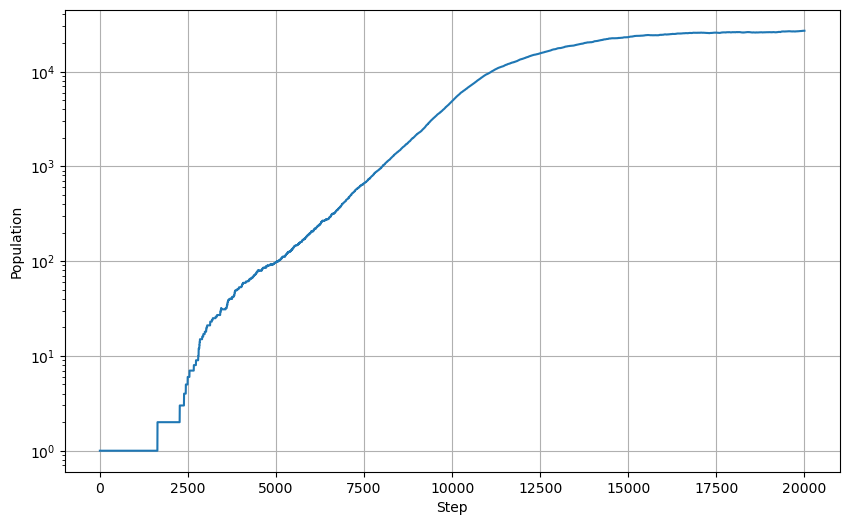

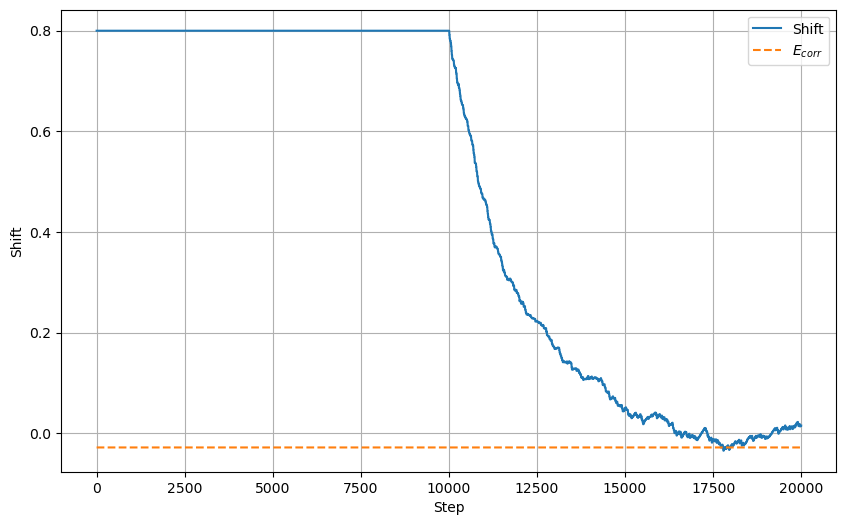

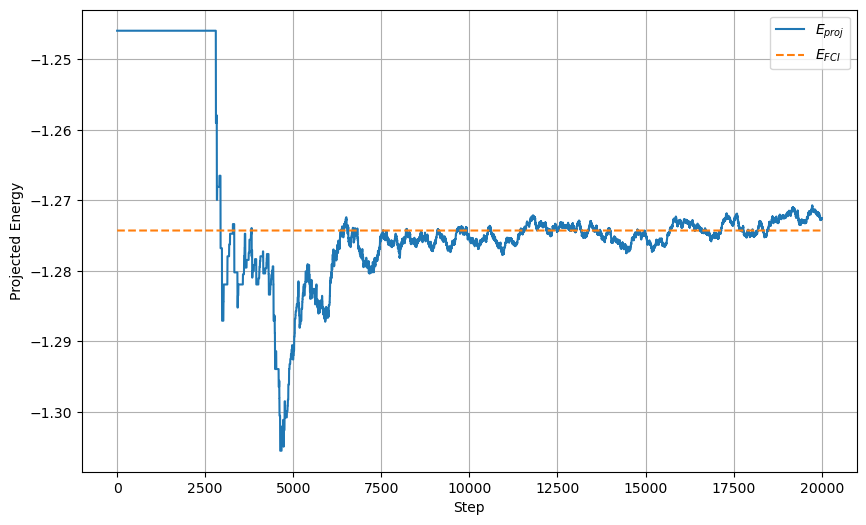

In [50]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.8, n_steps=20000, n_prod=10000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
# print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ STO-3G
FCI行列は225x225

--- K Matrix shape:(225, 225) ---
[[ 0.00000000e+00  1.27143113e-08 -1.26874938e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143113e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26874938e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.39953052e+00
   1.29249641e-17 -2.83496841e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.29249641e-17
   6.44660276e+00  2.86714800e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.83496841e-18
   2.86714800e-17  6.48034104e+00]]


  2%|▉                                            | 843/40000 [00:00<00:04, 8428.72it/s, E_proj=-7.914707, n_walkwers=5, shift=0.70000]

0 step
  1 walkers on 0th determinant
1000 step
  1 walkers on 0th determinant
2000 step
  3 walkers on 0th determinant
  1 walkers on 25th determinant
  -1 walkers on 160th determinant


 15%|██████                                   | 5867/40000 [00:00<00:02, 16793.29it/s, E_proj=-7.877137, n_walkwers=261, shift=0.70000]

3000 step
  7 walkers on 0th determinant
  2 walkers on 15th determinant
  -2 walkers on 1th determinant
  1 walkers on 25th determinant
  1 walkers on 63th determinant
4000 step
  14 walkers on 0th determinant
  -2 walkers on 1th determinant
  2 walkers on 25th determinant
  2 walkers on 15th determinant
  -1 walkers on 160th determinant
  -1 walkers on 96th determinant
  -1 walkers on 31th determinant
5000 step
  24 walkers on 0th determinant
  -4 walkers on 1th determinant
  3 walkers on 15th determinant
  3 walkers on 25th determinant
  -2 walkers on 160th determinant
  1 walkers on 10th determinant
  1 walkers on 151th determinant
  -1 walkers on 48th determinant
6000 step
  47 walkers on 0th determinant
  9 walkers on 15th determinant
  8 walkers on 25th determinant
  -6 walkers on 1th determinant
  -6 walkers on 160th determinant
  2 walkers on 10th determinant
  -2 walkers on 48th determinant
  2 walkers on 96th determinant
  1 walkers on 97th determinant
  1 walkers on 126th d

 32%|████████████▍                          | 12724/40000 [00:00<00:01, 18783.35it/s, E_proj=-7.875320, n_walkwers=4301, shift=0.70000]

9000 step
  343 walkers on 0th determinant
  37 walkers on 15th determinant
  28 walkers on 25th determinant
  -21 walkers on 1th determinant
  13 walkers on 10th determinant
  13 walkers on 151th determinant
  -10 walkers on 16th determinant
  -7 walkers on 48th determinant
  -7 walkers on 160th determinant
  -6 walkers on 96th determinant
  ... more
10000 step
  696 walkers on 0th determinant
  72 walkers on 15th determinant
  -54 walkers on 160th determinant
  48 walkers on 25th determinant
  48 walkers on 151th determinant
  -31 walkers on 1th determinant
  -23 walkers on 96th determinant
  -20 walkers on 16th determinant
  18 walkers on 10th determinant
  -14 walkers on 48th determinant
  ... more
11000 step
  1451 walkers on 0th determinant
  165 walkers on 15th determinant
  -154 walkers on 160th determinant
  95 walkers on 25th determinant
  -68 walkers on 48th determinant
  67 walkers on 151th determinant
  -45 walkers on 1th determinant
  -34 walkers on 16th determinant
  -26

 43%|███████████████▊                     | 17041/40000 [00:00<00:01, 20227.93it/s, E_proj=-7.887071, n_walkwers=161178, shift=0.70000]

13000 step
  6057 walkers on 0th determinant
  566 walkers on 15th determinant
  411 walkers on 25th determinant
  394 walkers on 151th determinant
  -305 walkers on 160th determinant
  -224 walkers on 48th determinant
  -214 walkers on 96th determinant
  -193 walkers on 16th determinant
  -116 walkers on 1th determinant
  61 walkers on 10th determinant
  ... more
14000 step
  12612 walkers on 0th determinant
  1147 walkers on 15th determinant
  904 walkers on 25th determinant
  802 walkers on 151th determinant
  -760 walkers on 160th determinant
  -487 walkers on 96th determinant
  -455 walkers on 16th determinant
  -442 walkers on 48th determinant
  138 walkers on 10th determinant
  -134 walkers on 1th determinant
  ... more
15000 step
  25703 walkers on 0th determinant
  -2649 walkers on 160th determinant
  2158 walkers on 15th determinant
  1547 walkers on 25th determinant
  1175 walkers on 151th determinant
  -824 walkers on 16th determinant
  -674 walkers on 96th determinant
  -5

 53%|███████████████████▏                | 21313/40000 [00:01<00:00, 20793.50it/s, E_proj=-7.882275, n_walkwers=3932276, shift=0.35961]

18000 step
  219823 walkers on 0th determinant
  -18523 walkers on 160th determinant
  16970 walkers on 15th determinant
  16830 walkers on 25th determinant
  15430 walkers on 151th determinant
  -7643 walkers on 16th determinant
  -5008 walkers on 48th determinant
  -5000 walkers on 96th determinant
  2070 walkers on 10th determinant
  974 walkers on 1th determinant
  ... more
19000 step
  453524 walkers on 0th determinant
  -48175 walkers on 160th determinant
  32747 walkers on 25th determinant
  31866 walkers on 15th determinant
  25774 walkers on 151th determinant
  -15478 walkers on 16th determinant
  7314 walkers on 1th determinant
  -6312 walkers on 96th determinant
  4403 walkers on 10th determinant
  -2914 walkers on 48th determinant
  ... more
20000 step
  932840 walkers on 0th determinant
  -145388 walkers on 160th determinant
  64390 walkers on 15th determinant
  53545 walkers on 25th determinant
  45447 walkers on 151th determinant
  -34988 walkers on 48th determinant
  -2

 64%|██████████████████████▎            | 25479/40000 [00:01<00:00, 20483.29it/s, E_proj=-7.882485, n_walkwers=6712574, shift=-0.01786]

23000 step
  3447764 walkers on 0th determinant
  -409369 walkers on 160th determinant
  241748 walkers on 25th determinant
  190239 walkers on 15th determinant
  150073 walkers on 151th determinant
  -126858 walkers on 48th determinant
  -109843 walkers on 16th determinant
  -62339 walkers on 96th determinant
  52615 walkers on 1th determinant
  24560 walkers on 10th determinant
  ... more
24000 step
  3865068 walkers on 0th determinant
  -614682 walkers on 160th determinant
  375938 walkers on 25th determinant
  244950 walkers on 15th determinant
  211902 walkers on 151th determinant
  -126671 walkers on 48th determinant
  -125535 walkers on 16th determinant
  -81749 walkers on 96th determinant
  72447 walkers on 1th determinant
  24705 walkers on 10th determinant
  ... more
25000 step
  4346382 walkers on 0th determinant
  519869 walkers on 25th determinant
  -435550 walkers on 160th determinant
  324123 walkers on 15th determinant
  201003 walkers on 151th determinant
  -162952 wal

 74%|██████████████████████████▋         | 29585/40000 [00:01<00:00, 20297.25it/s, E_proj=-7.882884, n_walkwers=6752374, shift=0.01143]

27000 step
  4684057 walkers on 0th determinant
  -390666 walkers on 160th determinant
  307718 walkers on 25th determinant
  261305 walkers on 15th determinant
  166219 walkers on 151th determinant
  -137999 walkers on 48th determinant
  -121900 walkers on 16th determinant
  -116387 walkers on 96th determinant
  91030 walkers on 1th determinant
  26450 walkers on 10th determinant
  ... more
28000 step
  4431891 walkers on 0th determinant
  -553534 walkers on 160th determinant
  287745 walkers on 25th determinant
  230701 walkers on 151th determinant
  225772 walkers on 15th determinant
  -172845 walkers on 48th determinant
  -139774 walkers on 16th determinant
  99108 walkers on 1th determinant
  -79515 walkers on 96th determinant
  21176 walkers on 10th determinant
  ... more
29000 step
  4458018 walkers on 0th determinant
  -402690 walkers on 160th determinant
  273150 walkers on 25th determinant
  212687 walkers on 15th determinant
  208270 walkers on 151th determinant
  -169150 wa

 89%|███████████████████████████████▎   | 35755/40000 [00:01<00:00, 20511.75it/s, E_proj=-7.877918, n_walkwers=5783446, shift=-0.04943]

32000 step
  4867631 walkers on 0th determinant
  -890537 walkers on 160th determinant
  289369 walkers on 25th determinant
  235477 walkers on 15th determinant
  224672 walkers on 151th determinant
  -179437 walkers on 16th determinant
  -116517 walkers on 96th determinant
  -112878 walkers on 48th determinant
  103136 walkers on 1th determinant
  33741 walkers on 10th determinant
  ... more
33000 step
  5103254 walkers on 0th determinant
  -712488 walkers on 160th determinant
  348161 walkers on 25th determinant
  234527 walkers on 151th determinant
  207169 walkers on 15th determinant
  -171510 walkers on 48th determinant
  -146856 walkers on 16th determinant
  -129575 walkers on 96th determinant
  84094 walkers on 1th determinant
  32156 walkers on 10th determinant
  ... more
34000 step
  4756710 walkers on 0th determinant
  -540481 walkers on 160th determinant
  257973 walkers on 151th determinant
  241412 walkers on 25th determinant
  188710 walkers on 15th determinant
  -187201 

100%|███████████████████████████████████| 40000/40000 [00:02<00:00, 19431.17it/s, E_proj=-7.880511, n_walkwers=5258410, shift=-0.02283]


37000 step
  4003522 walkers on 0th determinant
  -331878 walkers on 160th determinant
  261580 walkers on 25th determinant
  -171124 walkers on 16th determinant
  143875 walkers on 15th determinant
  117681 walkers on 151th determinant
  70692 walkers on 1th determinant
  -53721 walkers on 96th determinant
  -26330 walkers on 48th determinant
  21157 walkers on 97th determinant
  ... more
38000 step
  3835009 walkers on 0th determinant
  -630840 walkers on 160th determinant
  308080 walkers on 25th determinant
  202066 walkers on 151th determinant
  -161335 walkers on 16th determinant
  129059 walkers on 15th determinant
  -96204 walkers on 96th determinant
  82192 walkers on 1th determinant
  -41620 walkers on 48th determinant
  23988 walkers on 111th determinant
  ... more
39000 step
  3718056 walkers on 0th determinant
  -384426 walkers on 160th determinant
  238811 walkers on 25th determinant
  199487 walkers on 151th determinant
  -149466 walkers on 16th determinant
  142896 walk

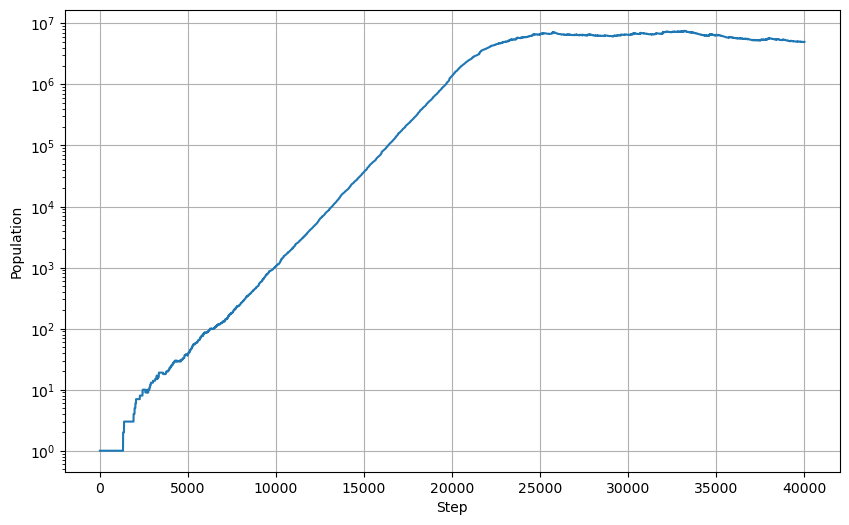

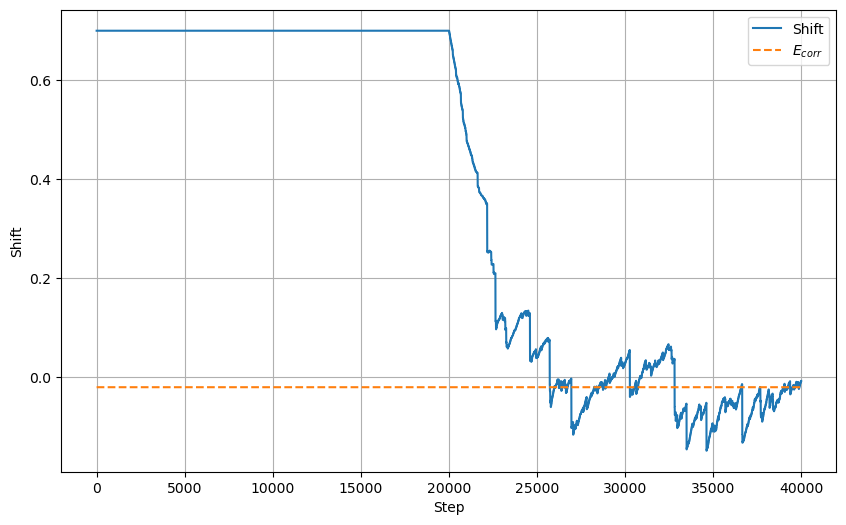

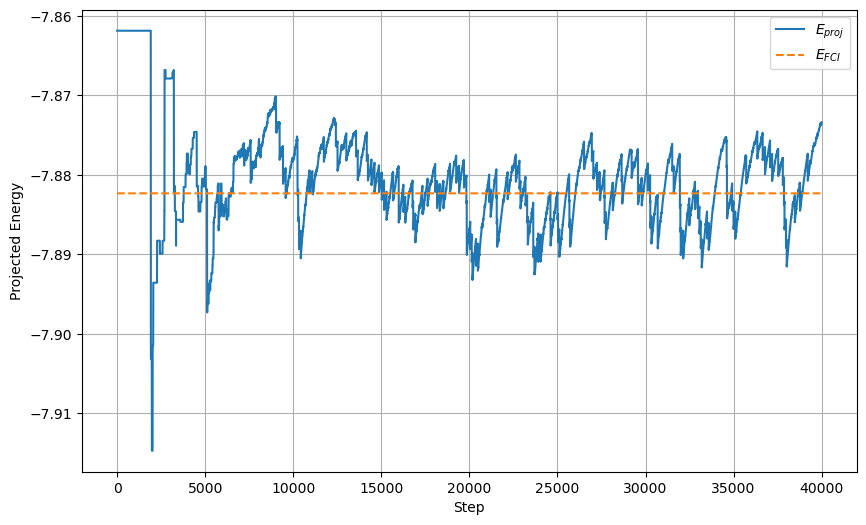

In [51]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    # basis="6-31g",
    # basis="6-31g(d)",
    # basis="6-31g(d,p)",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=40000, n_prod=20000, step_starting_shift_upd=20000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
# print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ 6-31g(d,p)

--- K Matrix shape:(29241, 29241) ---
[[ 7.10542736e-15 -8.13150970e-08 -8.36649976e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.13150970e-08  1.49183480e-01 -3.73250995e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.36649976e-09 -3.73250995e-03  2.21133798e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.59440770e+01
   7.87780870e-18  3.64496203e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  7.87780870e-18
   1.72874354e+01  1.00732586e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.64496203e-17
   1.00732586e-16  1.73991629e+01]]


  2%|▊                                            | 741/40000 [00:00<00:05, 7403.35it/s, E_proj=-8.002720, n_walkwers=7, shift=0.70000]

0 step
  1 walkers on 0th determinant
1000 step
  3 walkers on 0th determinant
  -2 walkers on 7831th determinant
  -1 walkers on 1032th determinant
  1 walkers on 8003th determinant


  8%|███▎                                       | 3042/40000 [00:00<00:04, 7636.23it/s, E_proj=-7.984753, n_walkwers=31, shift=0.70000]

2000 step
  4 walkers on 0th determinant
  2 walkers on 1802th determinant
  -1 walkers on 249th determinant
  1 walkers on 1720th determinant
  -1 walkers on 17955th determinant
  -1 walkers on 1071th determinant
  1 walkers on 1897th determinant
  1 walkers on 17991th determinant
  1 walkers on 4844th determinant
  -1 walkers on 1032th determinant
  ... more
3000 step
  13 walkers on 0th determinant
  1 walkers on 1725th determinant
  1 walkers on 4844th determinant
  -1 walkers on 1071th determinant
  1 walkers on 7750th determinant
  1 walkers on 4662th determinant
  -1 walkers on 3807th determinant
  -1 walkers on 3874th determinant
  -1 walkers on 4833th determinant
  -1 walkers on 2841th determinant
  ... more


 13%|█████▌                                    | 5304/40000 [00:00<00:04, 7388.76it/s, E_proj=-7.984689, n_walkwers=176, shift=0.70000]

4000 step
  36 walkers on 0th determinant
  -7 walkers on 7716th determinant
  -5 walkers on 7740th determinant
  -4 walkers on 568th determinant
  2 walkers on 7978th determinant
  -2 walkers on 3634th determinant
  -2 walkers on 26316th determinant
  -2 walkers on 1th determinant
  -1 walkers on 15652th determinant
  -1 walkers on 1081th determinant
  ... more
5000 step
  80 walkers on 0th determinant
  -7 walkers on 1162th determinant
  -6 walkers on 1801th determinant
  5 walkers on 186th determinant
  -5 walkers on 7716th determinant
  -4 walkers on 1th determinant
  -4 walkers on 1071th determinant
  -3 walkers on 15th determinant
  -3 walkers on 568th determinant
  2 walkers on 91th determinant
  ... more


 17%|███████                                   | 6769/40000 [00:00<00:04, 7018.53it/s, E_proj=-7.986707, n_walkwers=867, shift=0.70000]

6000 step
  160 walkers on 0th determinant
  -81 walkers on 7831th determinant
  -58 walkers on 3636th determinant
  -13 walkers on 1054th determinant
  -12 walkers on 167th determinant
  11 walkers on 9434th determinant
  -7 walkers on 15th determinant
  7 walkers on 171th determinant
  -6 walkers on 1th determinant
  -6 walkers on 78th determinant
  ... more
7000 step
  332 walkers on 0th determinant
  69 walkers on 568th determinant
  -35 walkers on 3636th determinant
  -26 walkers on 2580th determinant
  -16 walkers on 15th determinant
  -16 walkers on 1725th determinant
  13 walkers on 171th determinant
  -12 walkers on 1054th determinant
  -11 walkers on 1th determinant
  -10 walkers on 7831th determinant
  ... more


 22%|████████▉                                | 8765/40000 [00:01<00:05, 5957.64it/s, E_proj=-8.010820, n_walkwers=4756, shift=0.70000]

8000 step
  703 walkers on 0th determinant
  -146 walkers on 4794th determinant
  49 walkers on 568th determinant
  36 walkers on 11523th determinant
  -35 walkers on 24966th determinant
  -28 walkers on 1th determinant
  -25 walkers on 3636th determinant
  -21 walkers on 2580th determinant
  21 walkers on 171th determinant
  16 walkers on 18061th determinant
  ... more
9000 step
  1413 walkers on 0th determinant
  -1016 walkers on 9460th determinant
  286 walkers on 15666th determinant
  -205 walkers on 633th determinant
  175 walkers on 15653th determinant
  -139 walkers on 4794th determinant
  -104 walkers on 2580th determinant
  70 walkers on 19900th determinant
  -41 walkers on 2718th determinant
  -40 walkers on 9445th determinant
  ... more


 26%|██████████▏                            | 10474/40000 [00:01<00:06, 4815.99it/s, E_proj=-8.005633, n_walkwers=12135, shift=0.70000]

10000 step
  2801 walkers on 0th determinant
  -976 walkers on 181th determinant
  -785 walkers on 6166th determinant
  -681 walkers on 3612th determinant
  -510 walkers on 9460th determinant
  -455 walkers on 3594th determinant
  421 walkers on 9525th determinant
  397 walkers on 6156th determinant
  288 walkers on 78th determinant
  -200 walkers on 15th determinant
  ... more


 29%|███████████▏                           | 11416/40000 [00:01<00:06, 4148.76it/s, E_proj=-7.998179, n_walkwers=18395, shift=0.70000]

11000 step
  6444 walkers on 0th determinant
  -1016 walkers on 181th determinant
  -752 walkers on 6166th determinant
  -484 walkers on 3612th determinant
  -455 walkers on 23392th determinant
  -389 walkers on 3594th determinant
  344 walkers on 6156th determinant
  -308 walkers on 9433th determinant
  305 walkers on 78th determinant
  -304 walkers on 36th determinant
  ... more


 32%|████████████▎                          | 12613/40000 [00:02<00:07, 3600.54it/s, E_proj=-7.989170, n_walkwers=30862, shift=0.70000]

12000 step
  12804 walkers on 0th determinant
  1253 walkers on 17965th determinant
  1217 walkers on 10th determinant
  -1076 walkers on 181th determinant
  948 walkers on 7724th determinant
  -781 walkers on 15598th determinant
  -701 walkers on 6166th determinant
  -509 walkers on 6480th determinant
  484 walkers on 6156th determinant
  -483 walkers on 15th determinant
  ... more


 33%|████████████▉                          | 13318/40000 [00:02<00:08, 3219.82it/s, E_proj=-7.997689, n_walkwers=86338, shift=0.70000]

13000 step
  25691 walkers on 0th determinant
  -11203 walkers on 207th determinant
  -7103 walkers on 1711th determinant
  6436 walkers on 26199th determinant
  3545 walkers on 105th determinant
  -2905 walkers on 1071th determinant
  1904 walkers on 10th determinant
  -1578 walkers on 36th determinant
  -1144 walkers on 181th determinant
  840 walkers on 1710th determinant
  ... more


 36%|█████████████▌                        | 14234/40000 [00:02<00:09, 2740.24it/s, E_proj=-7.989592, n_walkwers=147497, shift=0.70000]

14000 step
  51822 walkers on 0th determinant
  -10526 walkers on 207th determinant
  -8746 walkers on 534th determinant
  -5838 walkers on 1711th determinant
  -5098 walkers on 1801th determinant
  -3779 walkers on 1722th determinant
  2643 walkers on 10th determinant
  2266 walkers on 105th determinant
  -2223 walkers on 1071th determinant
  2169 walkers on 1032th determinant
  ... more


 38%|██████████████▌                       | 15282/40000 [00:03<00:10, 2376.57it/s, E_proj=-8.021398, n_walkwers=395219, shift=0.70000]

15000 step
  104790 walkers on 0th determinant
  -64802 walkers on 7831th determinant
  -22005 walkers on 3636th determinant
  -18250 walkers on 7740th determinant
  -13183 walkers on 1725th determinant
  13102 walkers on 7398th determinant
  -11483 walkers on 207th determinant
  -10965 walkers on 7468th determinant
  -8829 walkers on 20523th determinant
  -8780 walkers on 26316th determinant
  ... more


 41%|███████████████▏                     | 16359/40000 [00:03<00:12, 1965.42it/s, E_proj=-7.991097, n_walkwers=550023, shift=-0.03161]

16000 step
  163757 walkers on 0th determinant
  -56555 walkers on 6157th determinant
  -32431 walkers on 2580th determinant
  -24083 walkers on 11352th determinant
  -19077 walkers on 1032th determinant
  17540 walkers on 15653th determinant
  -15110 walkers on 3636th determinant
  -11123 walkers on 15824th determinant
  9730 walkers on 15823th determinant
  -9256 walkers on 1711th determinant
  ... more


 43%|████████████████                     | 17334/40000 [00:04<00:11, 1938.04it/s, E_proj=-8.008264, n_walkwers=559584, shift=-0.13868]

17000 step
  184860 walkers on 0th determinant
  -42536 walkers on 3594th determinant
  -37900 walkers on 23392th determinant
  -35644 walkers on 1711th determinant
  -28612 walkers on 6157th determinant
  14506 walkers on 6419th determinant
  -13113 walkers on 2580th determinant
  -11088 walkers on 1032th determinant
  -10621 walkers on 2575th determinant
  9685 walkers on 18128th determinant
  ... more


 45%|████████████████▊                    | 18177/40000 [00:04<00:10, 2066.40it/s, E_proj=-7.994803, n_walkwers=440959, shift=-0.17211]

18000 step
  142976 walkers on 0th determinant
  -36809 walkers on 1032th determinant
  -36039 walkers on 3594th determinant
  -18728 walkers on 6192th determinant
  -14729 walkers on 20565th determinant
  -14088 walkers on 1711th determinant
  13804 walkers on 172th determinant
  -10803 walkers on 6157th determinant
  7761 walkers on 15742th determinant
  6681 walkers on 9433th determinant
  ... more


 49%|██████████████████▍                   | 19421/40000 [00:05<00:10, 2021.02it/s, E_proj=-7.989963, n_walkwers=358626, shift=0.01073]

19000 step
  141849 walkers on 0th determinant
  -35010 walkers on 1711th determinant
  -25602 walkers on 7701th determinant
  -14323 walkers on 3594th determinant
  -13800 walkers on 1032th determinant
  -8270 walkers on 633th determinant
  -6391 walkers on 9063th determinant
  -6266 walkers on 6192th determinant
  6012 walkers on 172th determinant
  -4203 walkers on 6157th determinant
  ... more


 51%|██████████████████▊                  | 20347/40000 [00:05<00:08, 2228.49it/s, E_proj=-8.008730, n_walkwers=369030, shift=-0.19778]

20000 step
  117551 walkers on 0th determinant
  -72867 walkers on 7740th determinant
  -26737 walkers on 7701th determinant
  -15270 walkers on 1711th determinant
  -14911 walkers on 1032th determinant
  -5414 walkers on 3594th determinant
  4630 walkers on 6309th determinant
  4576 walkers on 15886th determinant
  -3544 walkers on 26439th determinant
  3364 walkers on 7815th determinant
  ... more


 53%|███████████████████▋                 | 21261/40000 [00:06<00:08, 2171.32it/s, E_proj=-7.999096, n_walkwers=373220, shift=-0.09830]

21000 step
  105725 walkers on 0th determinant
  -25921 walkers on 15652th determinant
  22701 walkers on 6247th determinant
  -19907 walkers on 36th determinant
  -16236 walkers on 7740th determinant
  11741 walkers on 4816th determinant
  10550 walkers on 5014th determinant
  -8806 walkers on 7701th determinant
  7550 walkers on 3594th determinant
  -7313 walkers on 1711th determinant
  ... more


 56%|█████████████████████▏                | 22367/40000 [00:06<00:09, 1902.51it/s, E_proj=-7.985919, n_walkwers=225035, shift=0.11119]

22000 step
  92025 walkers on 0th determinant
  -11288 walkers on 36th determinant
  -5735 walkers on 11352th determinant
  5240 walkers on 6247th determinant
  4667 walkers on 15666th determinant
  4193 walkers on 4816th determinant
  -4035 walkers on 15652th determinant
  -3374 walkers on 1711th determinant
  3204 walkers on 3594th determinant
  -3094 walkers on 171th determinant
  ... more


 58%|█████████████████████▌               | 23261/40000 [00:07<00:07, 2166.98it/s, E_proj=-7.984555, n_walkwers=211769, shift=-0.03283]

23000 step
  93599 walkers on 0th determinant
  -7893 walkers on 36th determinant
  -6820 walkers on 20523th determinant
  -5862 walkers on 2580th determinant
  -5613 walkers on 7831th determinant
  4864 walkers on 5472th determinant
  3606 walkers on 1815th determinant
  3003 walkers on 3612th determinant
  2797 walkers on 3783th determinant
  -2647 walkers on 171th determinant
  ... more


 61%|██████████████████████▍              | 24256/40000 [00:07<00:06, 2387.50it/s, E_proj=-7.989661, n_walkwers=246751, shift=-0.09557]

24000 step
  99691 walkers on 0th determinant
  23726 walkers on 276th determinant
  -19751 walkers on 172th determinant
  -8486 walkers on 1711th determinant
  -6987 walkers on 1725th determinant
  6700 walkers on 97th determinant
  -6602 walkers on 36th determinant
  -4925 walkers on 20565th determinant
  4640 walkers on 91th determinant
  -3660 walkers on 6157th determinant
  ... more


 63%|███████████████████████▎             | 25221/40000 [00:08<00:06, 2330.67it/s, E_proj=-8.003358, n_walkwers=322160, shift=-0.04946]

25000 step
  85040 walkers on 0th determinant
  -20929 walkers on 9460th determinant
  -20651 walkers on 9411th determinant
  17174 walkers on 15597th determinant
  -13939 walkers on 4924th determinant
  9460 walkers on 2670th determinant
  -8254 walkers on 172th determinant
  7963 walkers on 3646th determinant
  6589 walkers on 2566th determinant
  -6315 walkers on 2752th determinant
  ... more


 66%|█████████████████████████             | 26341/40000 [00:08<00:06, 2118.91it/s, E_proj=-7.987781, n_walkwers=269736, shift=0.28555]

26000 step
  100381 walkers on 0th determinant
  -9199 walkers on 9411th determinant
  7660 walkers on 15597th determinant
  -6026 walkers on 9460th determinant
  -5736 walkers on 4843th determinant
  -5080 walkers on 172th determinant
  -4657 walkers on 15666th determinant
  -4483 walkers on 26173th determinant
  4367 walkers on 91th determinant
  4113 walkers on 2566th determinant
  ... more


 68%|█████████████████████████▏           | 27257/40000 [00:09<00:05, 2276.31it/s, E_proj=-7.986510, n_walkwers=267865, shift=-0.21024]

27000 step
  107538 walkers on 0th determinant
  -26087 walkers on 172th determinant
  -19413 walkers on 11352th determinant
  -6373 walkers on 15576th determinant
  4804 walkers on 433th determinant
  -4563 walkers on 3727th determinant
  -3557 walkers on 9411th determinant
  3051 walkers on 2566th determinant
  -2922 walkers on 36th determinant
  2892 walkers on 18108th determinant
  ... more


 71%|███████████████████████████           | 28485/40000 [00:09<00:04, 2440.88it/s, E_proj=-8.003237, n_walkwers=324644, shift=0.07095]

28000 step
  103695 walkers on 0th determinant
  -52971 walkers on 6157th determinant
  -30347 walkers on 15714th determinant
  -16730 walkers on 1th determinant
  -13944 walkers on 20541th determinant
  -12902 walkers on 172th determinant
  -8454 walkers on 3817th determinant
  5617 walkers on 9461th determinant
  -4429 walkers on 17253th determinant
  -3948 walkers on 11352th determinant
  ... more


 73%|███████████████████████████▊          | 29213/40000 [00:09<00:04, 2330.04it/s, E_proj=-7.989993, n_walkwers=369005, shift=0.33876]

29000 step
  128824 walkers on 0th determinant
  -33074 walkers on 3636th determinant
  -31062 walkers on 6157th determinant
  -14432 walkers on 1th determinant
  -10287 walkers on 2601th determinant
  -8572 walkers on 2580th determinant
  -7996 walkers on 172th determinant
  7109 walkers on 4816th determinant
  -6041 walkers on 7815th determinant
  4781 walkers on 6192th determinant
  ... more


 76%|████████████████████████████▊         | 30317/40000 [00:10<00:04, 2080.21it/s, E_proj=-7.983134, n_walkwers=380639, shift=0.10088]

30000 step
  144568 walkers on 0th determinant
  -16535 walkers on 6157th determinant
  -15042 walkers on 7723th determinant
  -14003 walkers on 1th determinant
  -12307 walkers on 3636th determinant
  -12179 walkers on 172th determinant
  11506 walkers on 2566th determinant
  7429 walkers on 7698th determinant
  6153 walkers on 7740th determinant
  6097 walkers on 4833th determinant
  ... more


 78%|█████████████████████████████        | 31355/40000 [00:11<00:04, 1969.93it/s, E_proj=-8.001840, n_walkwers=491020, shift=-0.23514]

31000 step
  113280 walkers on 0th determinant
  44397 walkers on 20575th determinant
  -29727 walkers on 181th determinant
  -20515 walkers on 3612th determinant
  -19594 walkers on 7716th determinant
  -17050 walkers on 1th determinant
  -12702 walkers on 1071th determinant
  -11443 walkers on 2580th determinant
  -10585 walkers on 172th determinant
  10113 walkers on 15576th determinant
  ... more


 81%|██████████████████████████████▊       | 32388/40000 [00:11<00:03, 2076.84it/s, E_proj=-8.006824, n_walkwers=366050, shift=0.09812]

32000 step
  107931 walkers on 0th determinant
  -55628 walkers on 15714th determinant
  -14812 walkers on 181th determinant
  -13921 walkers on 1th determinant
  10075 walkers on 1815th determinant
  -8160 walkers on 7716th determinant
  -7887 walkers on 3612th determinant
  7397 walkers on 4816th determinant
  -6585 walkers on 172th determinant
  6087 walkers on 2566th determinant
  ... more


 83%|███████████████████████████████▌      | 33228/40000 [00:11<00:03, 1975.37it/s, E_proj=-7.993429, n_walkwers=372645, shift=0.25294]

33000 step
  132386 walkers on 0th determinant
  -44975 walkers on 3636th determinant
  -19340 walkers on 1th determinant
  -12588 walkers on 10th determinant
  11181 walkers on 18046th determinant
  -9920 walkers on 181th determinant
  8867 walkers on 17965th determinant
  -7657 walkers on 172th determinant
  5025 walkers on 2566th determinant
  -4170 walkers on 18142th determinant
  ... more


 86%|████████████████████████████████▌     | 34274/40000 [00:12<00:02, 2015.50it/s, E_proj=-7.989687, n_walkwers=549297, shift=0.21037]

34000 step
  174882 walkers on 0th determinant
  -42664 walkers on 181th determinant
  -27827 walkers on 516th determinant
  -22091 walkers on 1th determinant
  -20081 walkers on 3636th determinant
  -18669 walkers on 2062th determinant
  -13155 walkers on 10th determinant
  -12400 walkers on 1726th determinant
  -11898 walkers on 2827th determinant
  9570 walkers on 2580th determinant
  ... more


 88%|█████████████████████████████████▍    | 35235/40000 [00:12<00:02, 1802.22it/s, E_proj=-7.986605, n_walkwers=647812, shift=0.25780]

35000 step
  234470 walkers on 0th determinant
  -30382 walkers on 181th determinant
  -25212 walkers on 1th determinant
  -18394 walkers on 10th determinant
  -18335 walkers on 516th determinant
  -15728 walkers on 186th determinant
  -14072 walkers on 26173th determinant
  -13710 walkers on 172th determinant
  12490 walkers on 171th determinant
  12018 walkers on 213th determinant
  ... more


 91%|█████████████████████████████████▋   | 36371/40000 [00:13<00:01, 1894.42it/s, E_proj=-7.992742, n_walkwers=601406, shift=-0.26046]

36000 step
  217876 walkers on 0th determinant
  -74711 walkers on 207th determinant
  -39375 walkers on 7698th determinant
  -19321 walkers on 1th determinant
  -15571 walkers on 181th determinant
  13107 walkers on 15562th determinant
  -11344 walkers on 1892th determinant
  9952 walkers on 171th determinant
  -9779 walkers on 516th determinant
  8648 walkers on 1897th determinant
  ... more


 94%|██████████████████████████████████▌  | 37410/40000 [00:14<00:01, 2036.91it/s, E_proj=-7.984730, n_walkwers=502723, shift=-0.07901]

37000 step
  214395 walkers on 0th determinant
  -30154 walkers on 207th determinant
  -15483 walkers on 1863th determinant
  -15011 walkers on 1th determinant
  -13895 walkers on 1029th determinant
  -12730 walkers on 7698th determinant
  11912 walkers on 1802th determinant
  -8906 walkers on 2746th determinant
  7382 walkers on 171th determinant
  6668 walkers on 13416th determinant
  ... more


 96%|███████████████████████████████████▎ | 38222/40000 [00:14<00:00, 1977.02it/s, E_proj=-7.984465, n_walkwers=449623, shift=-0.16621]

38000 step
  181689 walkers on 0th determinant
  -26193 walkers on 3612th determinant
  18446 walkers on 15666th determinant
  14246 walkers on 36th determinant
  -10496 walkers on 1th determinant
  10272 walkers on 249th determinant
  -7572 walkers on 20th determinant
  6266 walkers on 1726th determinant
  -6172 walkers on 1029th determinant
  -6009 walkers on 78th determinant
  ... more


 98%|████████████████████████████████████▍| 39363/40000 [00:15<00:00, 2319.95it/s, E_proj=-7.986039, n_walkwers=294753, shift=-0.23698]

39000 step
  136566 walkers on 0th determinant
  -15009 walkers on 2575th determinant
  -10513 walkers on 3727th determinant
  7472 walkers on 1815th determinant
  -7443 walkers on 3612th determinant
  7221 walkers on 36th determinant
  -6892 walkers on 1th determinant
  -5542 walkers on 15598th determinant
  -4962 walkers on 16597th determinant
  4386 walkers on 6156th determinant
  ... more


100%|█████████████████████████████████████| 40000/40000 [00:15<00:00, 2622.11it/s, E_proj=-7.986039, n_walkwers=294753, shift=-0.23698]



---- Walkers (result) ----
  48757 walkers on 0th determinant
  -14711 walkers on 1746th determinant
  -14511 walkers on 7740th determinant
  -13093 walkers on 9433th determinant
  -6443 walkers on 1711th determinant
  4399 walkers on 7745th determinant
  -3429 walkers on 6157th determinant
  -3003 walkers on 7911th determinant
  2360 walkers on 18046th determinant
  -2217 walkers on 2575th determinant
  ... more
------------------------------
FCI Energy: -8.008671 Ha
FCIQMC Energy: -7.992483 ±  0.004537 Ha


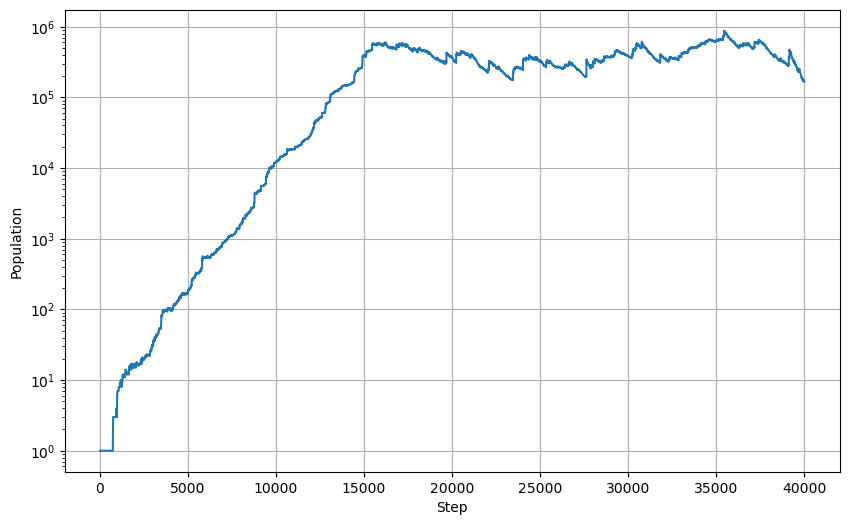

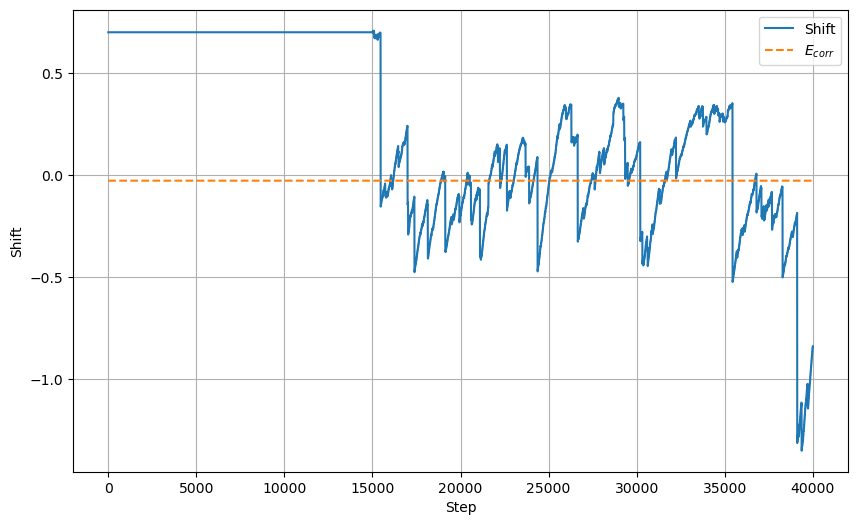

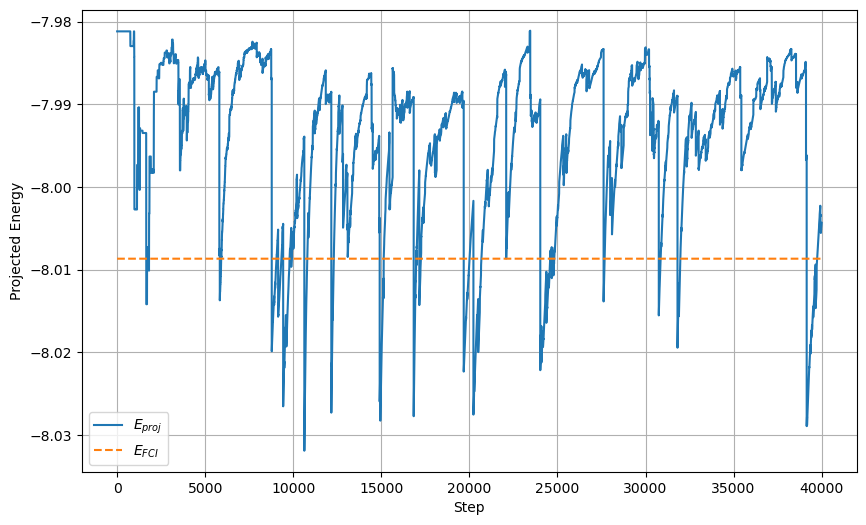

In [53]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="6-31g(d,p)",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=40000, n_prod=15000, step_starting_shift_upd=15000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
# print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## 外挿：${LiH}$ STO-3G ステップ数vs.エネルギー
ステップ数を増やすと非常に実行に時間がかかる。

--- FCI Matrix ---
(225, 225)
[[-7.86186477e+00  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08 -7.70892352e+00 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02 -5.80885774e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.46233425e+00
   1.50382491e-17  8.78436185e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.50382491e-17
  -1.41526201e+00 -3.47698264e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.78436185e-18
  -3.47698264e-17 -1.38152373e+00]]
--- K Matrix ---
[[-1.77635684e-15  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 .

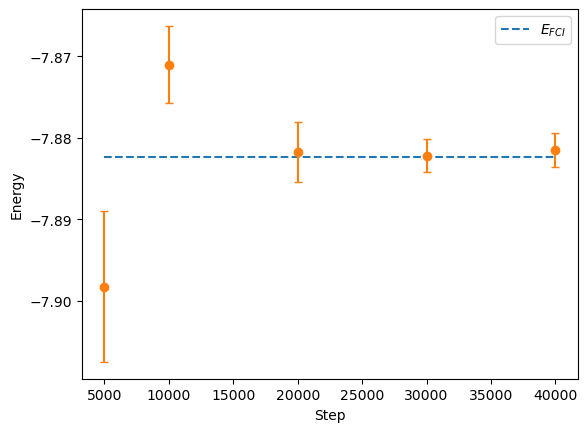

In [13]:
from pyscf import gto

n_steps_arr = [5000, 10000, 20000, 30000, 40000]

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    spin=0,      # singlet
    verbose=0
)

E = []
sd = []

for n_steps in n_steps_arr:
    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=1, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)

E_fci_arr = np.full_like(n_steps_arr, E_fci, dtype=float)
plt.plot(n_steps_arr, E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
plt.errorbar(n_steps_arr, E, yerr=sd, fmt='o', capsize=3)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()

## ${N_2}$ at equilibrium
FCI行列が巨大過ぎて生成出来ない。必要な成分のみ取ってくる実装（on the fly?）に変える必要がありそう

In [ ]:
from pyscf import gto

# N2 at equilibriumの定義
R_bohr = 2.068     # a0
R_ang = R_bohr * 0.529177

mol = gto.M(
    atom=f"N 0 0 0; N 0 0 {R_ang}",
    basis="cc-pVDZ",
    unit="Angstrom",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=1000, n_prod=500, step_starting_shift_upd=100)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## 外挿用（Det数:エネルギー）の共通関数を定義

In [77]:
def inverse_fit(N_det, E):
    x = 1.0 / N_det
    a, E_inf = np.polyfit(x, E, 1)
    fn = lambda N_det: a/N_det + E_inf    
    return a, E_inf, fn

def plot_extrapolation_to_inf_det(N_det, E, E_sd, fn):    
    N_det_fit = np.linspace(N_det.min(), N_det.max(), 500)
    E_fit = fn(N_det_fit)

    # plt.scatter(N_det, E, label="data")
    plt.plot(N_det_fit, E_fit, label=r"fit: $E_\infty + a/N$")
    plt.errorbar(N_det, E, yerr=sd, fmt='o', capsize=3, label=r"$E_{est}$")
    plt.xlabel("Number of determinants")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

## 外挿：${H_2}$ 基底数vs.エネルギー 真のEを値を推測する

Starting FCIQMC with the 6-31g basis set.


100%|█████████████████████████████████████| 40000/40000 [00:01<00:00, 23942.73it/s, E_proj=-1.150584, n_walkwers=22048, shift=-0.01779]


Starting FCIQMC with the 6-31g(d) basis set.


100%|█████████████████████████████████████| 40000/40000 [00:01<00:00, 24916.71it/s, E_proj=-1.150740, n_walkwers=32219, shift=-0.04843]


Starting FCIQMC with the 6-31g(d,p) basis set.


100%|████████████████████████████████████| 40000/40000 [00:01<00:00, 22050.58it/s, E_proj=-1.166947, n_walkwers=212620, shift=-0.04302]


Starting FCIQMC with the 6-311G(d,p) basis set.


100%|██████████████████████████████████████| 40000/40000 [00:01<00:00, 21397.11it/s, E_proj=-1.163537, n_walkwers=38250, shift=0.02503]


All FCIQMC calculations have completed.
E_inf: -1.1696610717244493


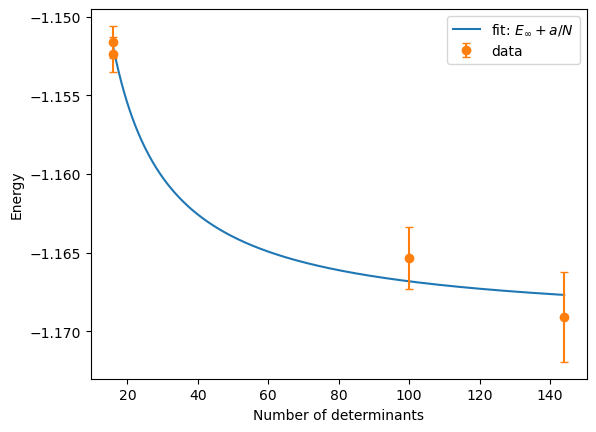

In [67]:
from pyscf import gto

# mol_1 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
mol_2 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g', verbose=0)
mol_3 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g(d)', verbose=0)
mol_4 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g(d,p)', verbose=0)
mol_5 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-311G(d,p)', verbose=0)
mols = [mol_2, mol_3, mol_4, mol_5]

n_steps = 40000
E = []
sd = []
N_det = np.zeros(len(mols))

for i, mol in enumerate(mols):
    print(f"Starting FCIQMC with the {mol.basis} basis set.")
    
    # determinantの数だけ欲しいが、molからは得られなかったので、
    # 冗長ではあるが、FCI Hamiltonianを生成して、行列の次元数を参照する
    H_mat, _, _ = build_hamiltonian(mol)

    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)
    N_det[i] = H_mat.shape[0]

print("All FCIQMC calculations have completed.")

_, E_inf, fn = inverse_fit(N_det, E)
print(f"E_inf: {E_inf}")

plot_extrapolation_to_inf_det(N_det, E, sd, fn)

## 外挿：${LiH}$ 基底数vs.エネルギー 真のEを値を推測する

In [94]:
from pyscf import gto

mol_1 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='sto-3g', verbose=0)
mol_2 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g', verbose=0)
mol_3 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g(d)', verbose=0)
mol_4 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g(d,p)', verbose=0)
mols = [mol_1, mol_2, mol_3, mol_4]

n_steps = 40000
E = []
sd = []
N_det = np.zeros(len(mols))

for i, mol in enumerate(mols):
    print(f"Starting FCIQMC with the {mol.basis} basis set.")
    
    # determinantの数だけ欲しいが、molからは得られなかったので、
    # 冗長ではあるが、FCI Hamiltonianを生成して、行列の次元数を参照する
    H_mat, _, _ = build_hamiltonian(mol)

    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)
    N_det[i] = H_mat.shape[0]

print("All FCIQMC calculations have completed.")

Starting FCIQMC with the sto-3g basis set.


100%|█████████████████████████████████████| 40000/40000 [00:01<00:00, 20917.44it/s, E_proj=-7.890497, n_walkwers=19317, shift=-0.00632]


Starting FCIQMC with the 6-31g basis set.


100%|█████████████████████████████████████| 40000/40000 [00:04<00:00, 8720.41it/s, E_proj=-7.992278, n_walkwers=130485, shift=-0.09625]


Starting FCIQMC with the 6-31g(d) basis set.


100%|███████████████████████████████████████| 40000/40000 [00:05<00:00, 7668.21it/s, E_proj=-8.015704, n_walkwers=22326, shift=0.23067]


Starting FCIQMC with the 6-31g(d,p) basis set.


100%|████████████████████████████████████| 40000/40000 [00:23<00:00, 1728.46it/s, E_proj=-7.996771, n_walkwers=1.16e+8, shift=-0.00338]


All FCIQMC calculations have completed.



Number of determinants: [  225.  3025. 14400. 29241.]
Energies: [np.float64(-7.8845610540989455), np.float64(-7.995737094654705), np.float64(-7.998880057640228), np.float64(-7.992261680523714)]
FCI Energy: -8.008671440242631
E_inf: -7.999233457345603
E_sd: [np.float64(0.0023994205350067062), np.float64(0.009797223879538236), np.float64(0.013127975303349373), np.float64(0.006118168393845482)]


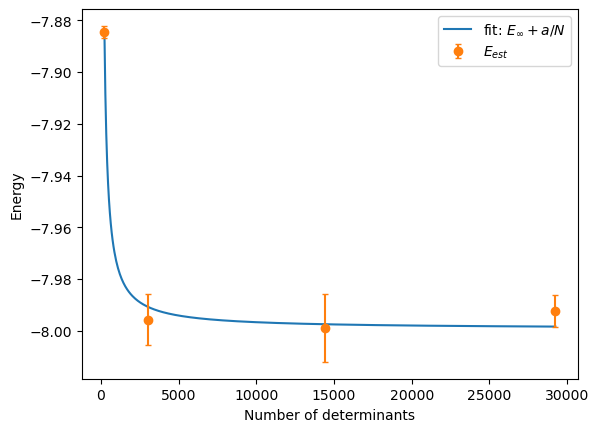

In [95]:
_, E_inf, fn = inverse_fit(N_det, E)

print(f"\nNumber of determinants: {N_det}")
print(f"Energies: {E}")
print(f"FCI Energy: {E_fci}")
print(f"E_inf: {E_inf}")
print(f"E_sd: {sd}")

plot_extrapolation_to_inf_det(N_det, E, sd, fn)